# K-Nearest Neighbor Regressor

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [5]:
import sklearn
import matplotlib
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), ('Scipy', scipy), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3
Scipy Version: 0.19.1
Sklearn Version: 0.19.0


In [6]:
import math
import numpy as np
import copy
import collections

class knn_regressor:
    
    def __init__(self, n_neighbors=5):
        """
        KNearestNeighbors is a distance based regressors that returns
        predictions based on the nearest points in the feature space.
        ---
        In: n_neighbors (int) - how many closest neighbors do we consider
        """
        if n_neighbors > 0:
            self.k = int(n_neighbors)
        else:
            print("n_neighbors must be >0. Set to 5!")
            self.k = 5
        self.X = None
        self.y = None
        
    def fit(self, X, y):
        """
        Makes a copy of the training data that can live within the class.
        Thus, the model can be serialized and used away from the original
        training data. 
        ---
        In: X (features), y (labels); both np.array or pandas dataframe/series
        """
        self.X = copy.copy(self.convert_to_array(X))
        self.y = copy.copy(self.convert_to_array(y))
        
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
        
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def predict(self, X):
        """
        Iterates through all points to predict, calculating the distance
        to all of the training points. It then passes that to a sorting function
        which returns the most common vote of the n_neighbors (k) closest training
        points.
        ___
        In: new data to predict (np.array, pandas series/dataframe)
        Out: predictions (np.array)
        """
        X = self.convert_to_array(X)
        results = []
        for x in X:
            local_results = []
            for (x2,y) in zip(self.X,self.y):
                local_results.append([self.dist_between_points(x,x2),y])
            results.append(self.get_final_predict(local_results))
        return np.array(results).reshape(-1,1)
            
    def get_final_predict(self,results):
        """
        Takes a list of [distance, label] pairs and sorts by distance,
        returning themean of the n_neighbors (k) closest points. 
        ---
        In: [[distance, label]] list of lists
        Output: class label (int)
        """
        results = sorted(results, key=lambda x: x[0])
        dists, votes = zip(*results)
        return np.mean(votes[:self.k])

    def dist_between_points(self, a, b):
        """
        Calculates the distance between two vectors.
        ---
        Inputs: a,b (np.arrays)
        Outputs: distance (float)"""
        assert np.array(a).shape == np.array(b).shape
        return np.sqrt(np.sum((a-b)**2))
    
    def score(self, X, y):
        """
        Uses the predict method to measure the (negative)
        mean squared error of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: negative mean squared error (float)
        """
        pred = self.predict(X)
        return -1.* np.mean((np.array(pred)-np.array(y))**2)

In [7]:
def get_data():
    x = np.linspace(-10,10,300)
    y = np.sin(x)
    return x, y

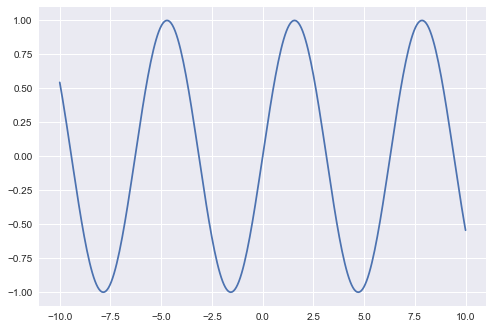

In [8]:
X,y = get_data()
plt.plot(X,y);

In [9]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    permute = np.random.permutation(len(y))
    return X[permute], y[permute]

def train_test_split_manual(X, y, test_size=0.3):
    nX, ny = shuffle_data(X,y)
    split_index = int(len(X)*test_size)
    testX = nX[:split_index]
    trainX = nX[split_index:]
    testy = ny[:split_index]
    trainy = ny[split_index:]
    return trainX, testX, trainy, testy

In [10]:
x_train, x_test, y_train, y_test = train_test_split_manual(X,y,test_size=0.3)

In [11]:
knn = knn_regressor(n_neighbors=5)
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

-0.96407085677986692

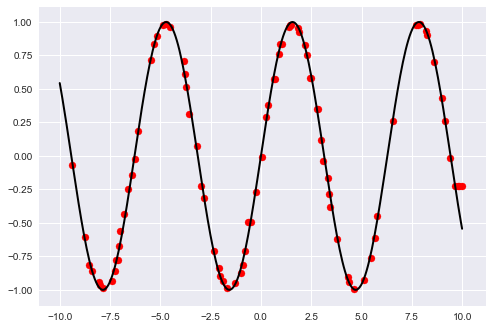

In [12]:
preds = knn.predict(x_test)
plt.plot(X,y,'k',lw=2,label='Truth')
plt.scatter(x_test, preds,c='r', label="Prediction")

In [13]:
from sklearn.neighbors import KNeighborsRegressor

sk_knn = KNeighborsRegressor(n_neighbors=5,algorithm='brute')
sk_knn.fit(x_train.reshape(-1,1),y_train.reshape(-1,1))
sk_knn.score(x_test.reshape(-1,1),y_test.reshape(-1,1))

0.99346626294502405

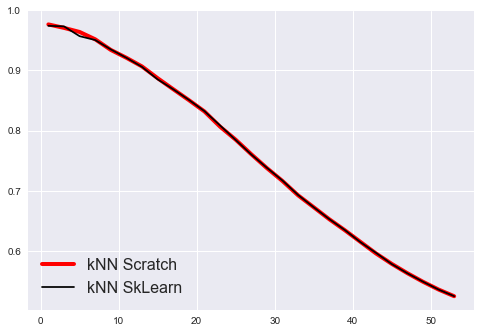

In [14]:
myscore = []
skscore = []
for k in range(1,55)[::2]:
    knn = knn_regressor(n_neighbors=k)
    knn.fit(x_train,y_train)
    myscore.append(-knn.score(x_test,y_test))
    sk_knn = KNeighborsRegressor(n_neighbors=k,algorithm='brute')
    sk_knn.fit(x_train.reshape(-1,1),y_train.reshape(-1,1))
    skscore.append(np.mean((sk_knn.predict(x_test.reshape(-1,1))-np.array(y_test))**2))
    
plt.plot(range(1,55)[::2],myscore,'r-',lw=4,label="kNN Scratch")
plt.plot(range(1,55)[::2],skscore,'-k',label="kNN SkLearn")
plt.legend(loc="lower left", fontsize=16);